In [ ]:
import pandas as pd
import re
import numpy as np

Посмотрим на данные

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/for myself/Тестовое Спутник/events filters.csv')
comments = pd.read_excel('/content/drive/MyDrive/for myself/Тестовое Спутник/comments.xlsx')

In [ ]:
df.head()

,event_category,event_action,event_label,total_events,unique_events
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2


In [ ]:
df.shape

(19092, 5)

В event label на 1 месте всегда название города

Отдельными столбцами выведем город и данные лейбла без лишних знаков

In [ ]:
df['city'] = df['event_label'].apply(lambda x: x[:x.find('/')-1] if x.find('/')!=-1 else x)

In [ ]:
df['event_label'] = df['event_label'].apply(lambda x: x[x.find('/')+2:] if x.find('/')!=-1 else '')

In [ ]:
df['label'] = df['event_label'].apply(lambda x: (re.sub("[0-9().:]", "", x)).lower())

In [ ]:
df.head()

,event_category,event_action,event_label,total_events,unique_events,city,label
0,city_landing,price_button_submit,Показать предложения (11),8,7,Tula,показать предложения
1,city_landing,price_button_submit,Показать предложения (39),12,10,Sochi,показать предложения
2,city_landing,search-tools-button_open,Сортировка,2,2,Penza,сортировка
3,city_landing,filters-categories_click,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,экскурсии в геленджике цены
4,city_landing,price_button_submit,Показать предложения (345),2,2,Moscow,показать предложения


Оставим на всякий случай лейбл без города полностью

Посмотрим, сколько всего уникальных городов представлено в выборке

In [ ]:
df['city'].unique()[:10]

array(['Tula', 'Sochi', 'Penza', 'Gelendzhik', 'Moscow', 'Vienna',
       'Vilnius', 'Irkutsk', 'Vladivostok', 'Krakow'], dtype=object)

In [ ]:
len(df['city'].unique())

651

#Первое
**что сделать:**


*необходимо проанализировать использование фильтров пользователями на страницах городов. вопросы, на которые стоит ответить:*


1. сколько людей пользуются фильтрами?
2. в каких городах фильтрами пользуются больше? в каких меньше?
3. какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”?
4. как часто люди пользуются выбором цены?


##**1. Сколько людей пользуются фильтрами?**

Как отследить людей, которые пользуются фильтрами?

Попытаемся определить, что такое "пользоваться фильтром".

Событие "открытие кнопки *фильтры/сортировки/категории*" еще не значит, что фильтром в итоге воспользовались, так же как и прожатие чекбоксов или другой процесс внутри фильтра. Если процесс не завершился применением фильтров, считаем, что фильтры не были использованы

Рассмотрим на примере одного города, как выглядят данные для событий "открытие фильтра", "применение фильтра" и "закрытие окошка фильтров"


In [ ]:
df[(df['event_action']=='search-tools-button_open') & (df['city']=='Abakan')]

,event_category,event_action,event_label,total_events,unique_events,city,label
54,city_landing,search-tools-button_open,Категории,5,4,Abakan,категории
16258,city_landing,search-tools-button_open,Выбрано: 0,3,3,Abakan,выбрано
16430,city_landing,search-tools-button_open,Фильтры,1,1,Abakan,фильтры
18940,city_landing,search-tools-button_open,Все,2,2,Abakan,все


In [ ]:
df[(df['event_action']=='price_button_submit') & (df['city']=='Abakan')]

,event_category,event_action,event_label,total_events,unique_events,city,label
2983,city_landing,price_button_submit,Показать предложения (8),1,1,Abakan,показать предложения
3243,city_landing,price_button_submit,Показать предложения (7),1,1,Abakan,показать предложения
11081,city_landing,price_button_submit,Показать предложения (21),2,2,Abakan,показать предложения
11338,city_landing,price_button_submit,Показать предложения (9),3,2,Abakan,показать предложения
12177,city_landing,price_button_submit,Показать предложения (5),2,1,Abakan,показать предложения
14773,city_landing,price_button_submit,Показать предложения (10),1,1,Abakan,показать предложения
15659,city_landing,price_button_submit,Показать предложения (1),1,1,Abakan,показать предложения


In [ ]:
df[(df['event_action']=='price_button_close') & (df['city']=='Abakan')]


,event_category,event_action,event_label,total_events,unique_events,city,label


Так как у нас нет данных по каждому отдельному пользователю, мы можем только предполагать количество пользователей, которые пользуются фильтрами.

Будем считать, что в рамках одного события unique_events - число уникальных пользователей, которые совершили действие (допускаем, что 1 сессия = 1 пользователь).

В рамках одной сессии пользователь может несколько раз нажимать как на кнопку "применить фильтры", так и "открыть фильтры".

Попробуем сравнить общее количество уникальных открытий фильтров и общим количеством применений фильторов.

In [ ]:
city_df = df[df['event_action']=='Page Visit'].groupby(['city'])['unique_events'].agg(['sum']).sort_values('sum', ascending=False)
city_df = city_df.reset_index()
city_df = city_df.rename(columns={'sum': 'visit'})

In [ ]:
city_df['open'] = city_df['city'].apply(lambda x: sum(df[(df['event_action']=='search-tools-button_open') & (df['city'] == x)]['unique_events']))
city_df['submit'] = city_df['city'].apply(lambda x: sum(df[(df['event_action']=='price_button_submit') & (df['city'] == x)]['unique_events']))
city_df['close'] = city_df['city'].apply(lambda x: sum(df[(df['event_action']=='price_button_close') & (df['city'] == x)]['unique_events']))

Посчитаем долю количества применений фильтра к общему количеству посещений страниц. Данные с достаточно маленькими значениями могут дать искажения (например, 2 посещения и 1 применение фильтра не очень показательно). Так что из данных выкинем города с общим количеством применений фильтров меньше 5.

In [ ]:
city_df = city_df[city_df['submit']>5]

In [ ]:
city_df['fil_usage'] = np.round((city_df['submit']/city_df['visit'])*100, 2)

<ipython-input-119-9aec72bbc34c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['fil_usage'] = np.round((city_df['submit']/city_df['visit'])*100, 2)


Посчитаем общее число применений фильтров

In [ ]:
sum(city_df['submit'])

62760

##**2. В каких городах фильтрами пользуются больше? в каких меньше?**

In [ ]:
city_df.sort_values('fil_usage', ascending=False).head(10)

,city,visit,open,submit,close,fil_usage
133,Larnaca,917,209,179,13,19.52
275,Ljubljana,124,29,23,3,18.55
121,Belgrade,1066,230,185,18,17.35
149,Paphos,694,131,112,6,16.14
89,Ayia Napa,1881,386,293,43,15.58
152,Protaras,663,102,91,5,13.73
163,Budva,549,76,69,6,12.57
330,Verona,65,10,8,1,12.31
40,Yerevan,6305,974,767,137,12.16
51,Cyprus,4197,649,494,77,11.77


In [ ]:
city_df.sort_values('fil_usage', ascending=False).tail(10)

,city,visit,open,submit,close,fil_usage
144,Khabarovsk,708,15,8,1,1.13
147,Simeiz,700,13,7,2,1.00
54,Abrau-Durso,4148,76,40,13,0.96
83,New Athos,2155,26,20,2,0.93
132,Goa,920,11,8,1,0.87
148,Izberbash,697,14,6,2,0.86
146,Hammamet,702,10,6,1,0.85
99,Astana,1648,33,13,4,0.79
127,Varadero,994,23,7,8,0.70
69,Chernobyl,3334,44,21,6,0.63


In [ ]:
filters_submit = sum(city_df['submit'])
filters_submit

62760

In [ ]:
df[df['label'].apply(lambda x: True if x.find('фильтр')!=-1 else False)].head()

,event_category,event_action,event_label,total_events,unique_events,city,label
13,city_landing,search-tools-button_open,Фильтры Выбрано: 1,9,9,Crete,фильтры выбрано
61,city_landing,search-tools-button_open,Фильтры,1,1,Tolyatti,фильтры
131,city_landing,search-tools-button_open,Фильтры Выбрано: 0,19,19,Adler,фильтры выбрано
182,city_landing,search-tools-button_open,Фильтры,276,218,Yerevan,фильтры
218,city_landing,search-tools-button_open,Фильтры Выбрано: 0,4,4,Yessentuki,фильтры выбрано


In [ ]:
df[df['label'].apply(lambda x: True if x.find('категор')!=-1 else False)].head()

,event_category,event_action,event_label,total_events,unique_events,city,label
27,city_landing,search-tools-button_open,Категории Все,4,4,Haifa,категории все
54,city_landing,search-tools-button_open,Категории,5,4,Abakan,категории
60,city_landing,search-tools-button_open,Категории,1,1,Tashkent,категории
63,city_landing,search-tools-button_open,Категории ЭКСКУРСИИ АНАПА 2021 АВГУСТ,1,1,Anapa,категории экскурсии анапа август
88,city_landing,search-tools-button_open,Категории,1,1,Leningrad Oblast,категории


In [ ]:
df[df['label'].apply(lambda x: True if x.find('сортиров')!=-1 else False)]

,event_category,event_action,event_label,total_events,unique_events,city,label
2,city_landing,search-tools-button_open,Сортировка,2,2,Penza,сортировка
95,city_landing,search-tools-button_open,Сортировка По рейтингу,4,4,Lazarevskoye,сортировка по рейтингу
133,city_landing,search-tools-button_open,Сортировка По рейтингу,1,1,Limassol,сортировка по рейтингу
157,city_landing,search-tools-button_open,Сортировка,2,2,Dusseldorf,сортировка
241,city_landing,search-tools-button_open,Сортировка По рейтингу,1,1,Ryazan,сортировка по рейтингу
...,...,...,...,...,...,...,...
18959,city_landing,search-tools-button_open,Сортировка,43,41,Ayia Napa,сортировка
18968,city_landing,search-tools-button_open,Сортировка,35,32,Belek,сортировка
19039,city_landing,search-tools-button_open,Сортировка,1,1,yantarny,сортировка
19053,city_landing,search-tools-button_open,Сортировка,11,11,Gagra,сортировка


In [ ]:
df[df['city'].apply(lambda x: True if x.find('Petropavlo')!=-1 else False)].head()

,event_category,event_action,event_label,total_events,unique_events,city,label
169,city_landing,search-tools-button_open,Выездные,1,1,Petropavlovsk-Kamchatsky,выездные
278,city_landing,price_button_close,,5,5,Petropavlovsk-Kamchatsky,
1423,city_landing,price_button_submit,Показать предложения (1),3,3,Petropavlovsk-Kamchatsky,показать предложения
1669,city_landing,price_button_submit,Показать предложения (13),1,1,Petropavlovsk-Kamchatsky,показать предложения
2080,city_landing,clear_filter_mobile,,3,3,Petropavlovsk-Kamchatsky,


In [ ]:
city_df[city_df['city']=='Petropavlovsk-Kamchatsky']

,city,visit,open,submit,close,fil_usage
177,Petropavlovsk-Kamchatsky,462,43,32,5,6.93


In [ ]:
city_df

,city,visit,open,submit,close,fil_usage
0,Saint Petersburg,231941,6645,5028,781,2.17
1,Moscow,134254,4384,3176,625,2.37
2,Kaliningrad,67996,6772,5222,1021,7.68
3,Kazan,51796,2425,1839,292,3.55
4,Sharm-el-Sheikh,43706,2065,1440,275,3.29
...,...,...,...,...,...,...
275,Ljubljana,124,29,23,3,18.55
282,Abakan,115,10,9,0,7.83
291,Porto,102,6,6,0,5.88
330,Verona,65,10,8,1,12.31


##**3. Какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”?**

Выбор каких-либо параметров в разделе "сортировка" и "категории" отмечается флагом *filters-categories_click*. Разделить "сортировку" и "категории" можно следующим образом: при выборе "сортировки" в label будет указано одно из 3: "по рейтингу", "сначала самые популярные", "сначала самые дешевые". Все остальное, соответственно, "категории".



In [ ]:
df[(df['label']=='сначала самые дешевые')].head()

,event_category,event_action,event_label,total_events,unique_events,city,label
11,city_landing,filters-categories_click,Сначала самые дешевые,62,50,Barcelona,сначала самые дешевые
78,city_landing,search-tools-button_open,Сначала самые дешевые,12,11,Antalya,сначала самые дешевые
266,city_landing,filters-categories_click,Сначала самые дешевые,22,20,Grozny,сначала самые дешевые
288,city_landing,filters-categories_click,Сначала самые дешевые,3,3,Thessaloniki,сначала самые дешевые
307,city_landing,filters-categories_click,Сначала самые дешевые,288,221,Moscow,сначала самые дешевые


Когда в лейбле указан тип сортировки, в event_action может быть два варианта - filters-categories_click (активация чекбоксов в разделах) и search-tools-button_open (открытие фильтров). Мы будем учитывать только те, в которых конкретно активируются чекбоксы.

Рассмотрим, сколько человек пользуются каждым типом сортировки

In [ ]:
rei =sum(df[(df['label']=='по рейтингу') & (df['event_action']=='filters-categories_click')]['unique_events'])
rei

1778

In [ ]:
pop = sum(df[(df['label']=='сначала самые популярные') & (df['event_action']=='filters-categories_click')]['unique_events'])
pop

6159

In [ ]:
cheap = sum(df[(df['label']=='сначала самые дешевые') & (df['event_action']=='filters-categories_click')]['unique_events'])
cheap

9445

In [ ]:
rei+pop+cheap

17382

Получается, что всего сортировкой воспользовались 17382 раз

Все остальные записи, у которых event_action равен filters-categories_click, соответственно, являются действиями по применению категорий.


In [ ]:
category = df[((df['label']!='сначала самые популярные') & (df['label']!='сначала самые дешевые') & (df['label']!='по рейтингу')) & (df['event_action']=='filters-categories_click')]
category.head()

,event_category,event_action,event_label,total_events,unique_events,city,label
3,city_landing,filters-categories_click,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,экскурсии в геленджике цены
9,city_landing,filters-categories_click,Необычные,3,3,Krakow,необычные
12,city_landing,filters-categories_click,Автобусные,42,32,Novorossiysk,автобусные
15,city_landing,filters-categories_click,Групповые,10,8,Sergiev Posad,групповые
23,city_landing,filters-categories_click,СЕМЕЙНЫЕ ЭКСКУРСИИ В ПЕТЕРБУРГЕ,2,1,Saint Petersburg,семейные экскурсии в петербурге


In [ ]:
sum(category['unique_events'])

45157

In [ ]:
sum(df[(df['event_action']=='filters-categories_click')]['unique_events'])-(rei+pop+cheap)

45157

Категории были выбраны 45157 раз

Попробуем подсчитать именно использование фильтров

Мы не можем посчитать число уникальных действий для каждого конкретного фильтра (цена, дата и т.д) так как мы пытаемся сравнить это число с использованием сортировок и категорий, в которых можно выбрать только по одному элементу. Поэтому попробуем найти среди действий "открытие фильтров" события с лейблом "фильтр" и будем считать это показателем используемости.

In [ ]:
df[(df['event_action']=='search-tools-button_open') & (df['label'].apply(lambda x: True if x.find('фильтр')!=-1 else False))].head()

,event_category,event_action,event_label,total_events,unique_events,city,label
13,city_landing,search-tools-button_open,Фильтры Выбрано: 1,9,9,Crete,фильтры выбрано
61,city_landing,search-tools-button_open,Фильтры,1,1,Tolyatti,фильтры
131,city_landing,search-tools-button_open,Фильтры Выбрано: 0,19,19,Adler,фильтры выбрано
182,city_landing,search-tools-button_open,Фильтры,276,218,Yerevan,фильтры
218,city_landing,search-tools-button_open,Фильтры Выбрано: 0,4,4,Yessentuki,фильтры выбрано


In [ ]:
sum(df[(df['event_action']=='search-tools-button_open') & (df['label'].apply(lambda x: True if x.find('фильтр')!=-1 else False))]['unique_events'])

19246

Получается, что фильтры были открыты 19246 раз

In [ ]:
df[(df['event_action']=='search-tools-button_open') & (df['label'].apply(lambda x: True if x.find('фильт')!=-1 else False))].head()

,event_category,event_action,event_label,total_events,unique_events,city,label
13,city_landing,search-tools-button_open,Фильтры Выбрано: 1,9,9,Crete,фильтры выбрано
61,city_landing,search-tools-button_open,Фильтры,1,1,Tolyatti,фильтры
131,city_landing,search-tools-button_open,Фильтры Выбрано: 0,19,19,Adler,фильтры выбрано
182,city_landing,search-tools-button_open,Фильтры,276,218,Yerevan,фильтры
218,city_landing,search-tools-button_open,Фильтры Выбрано: 0,4,4,Yessentuki,фильтры выбрано


In [ ]:
sum(df[(df['event_action']=='search-tools-button_open') & (df['label'].apply(lambda x: True if x.find('фильт')!=-1 else False))]['unique_events'])

19246

In [ ]:

df[(df['event_action'].apply(lambda x: True if (x.find('price_first')!=-1 or x.find('price_second')!=-1 or x.find('price_third')!=-1) else False))]

,event_category,event_action,event_label,total_events,unique_events,city,label
21,city_landing,price_third,,6,4,Petrozavodsk,
45,city_landing,price_third,,186,94,Saint Petersburg,
49,city_landing,price_second,,3,1,Thessaloniki,
132,city_landing,price_third,,4,3,Makhachkala,
253,city_landing,price_second,,55,35,Kislovodsk,
...,...,...,...,...,...,...,...
18914,city_landing,price_second,,30,20,Alushta,
18982,city_landing,price_second,,4,4,Tver,
18996,city_landing,price_first,,2,2,Stockholm,
19001,city_landing,price_first,,68,52,Pskov,


In [ ]:
filters_price = sum(df[(df['event_action'].apply(lambda x: True if (x.find('price_first')!=-1 or x.find('price_second')!=-1 or x.find('price_third')!=-1) else False))]['unique_events'])
filters_price

9266

In [ ]:
(filters_price/filters_submit)*100

14.764181007010835

In [ ]:
df[(df['event_action']=='filters-categories_click')]['label'].unique()

array(['экскурсии в геленджике цены', 'необычные',
       'сначала самые дешевые', 'автобусные', 'групповые',
       'семейные экскурсии в петербурге', 'обзорные', 'популярные',
       'гастрономические', 'выездные', 'экскурсии по г москва',
       'фотопрогулки', 'пешеходные', 'индивидуальные', 'по рейтингу',
       'вечерние экскурсии', 'саратовский лимонарий', 'автобусні',
       'сначала самые популярные', 'водные экскурсии в казани',
       'светлогорск', 'история и культура', 'авторские',
       'экскурсии в нижнем новгороде цены',
       'обзорная экскурсия по новосибирску', 'однодневные', 'музеи',
       'по уралу', 'для детей', 'экскурсии по шарм эль шейху',
       'парк цветов', 'билеты без очереди', 'ночные экскурсии',
       'заказать экскурсию в нижнем новгороде', 'экскурсии будапешт',
       'экскурсия по суздалю заказать',
       'прага достопримечательности экскурсии',
       'калининград экскурсии по городу',
       'однодневные экскурсии из твери на автобусе',
       

#**Второе**

Проверим нулевую гипотезу о равенстве долей против двусторонней альтернативы. Для этого воспользуемся z-критерием.

Установим уровень значимости ∝ = 0.05, т.е. вероятность допустить ошибку 1 рода будет равна 5 процентам (вероятность отвергнуть нулевую гипотезу при её верности, т.е. вероятность сказать, что изменения есть, когда их на самом деле нет)

H0: p1=p2

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm


n1, n2 = 5000, 5000  # размеры выборок
successes1, successes2 = 300, 450  # количество успехов (конверсий)

# Рассчитываем пропорции
p1 = successes1 / n1
p2 = successes2 / n2

# Выполняем z-тест
z_score, p_value = sm.stats.proportions_ztest([successes1, successes2], [n1, n2])

print(f'Рассчитанное значение статистики: {np.round(z_score, 3)}, p-value: {np.round(p_value, 5)}')

Рассчитанное значение статистики: -5.695, p-value: 0.0


Конверсия в бронирование для выборок А и Б

In [ ]:
p1, p2

(0.06, 0.09)

Достигнутый уровень значимости равен 0. Это меньше, чем заданный уровень значимости 0.05. Поэтому у нас есть основания отвергнуть нулевую гипотезу о равенстве долей.

Получается, что доли в выборках не равны => фильтры привели к статистически значимым изменениям в показателе конверсии.

In [ ]:
alfa = 0.05

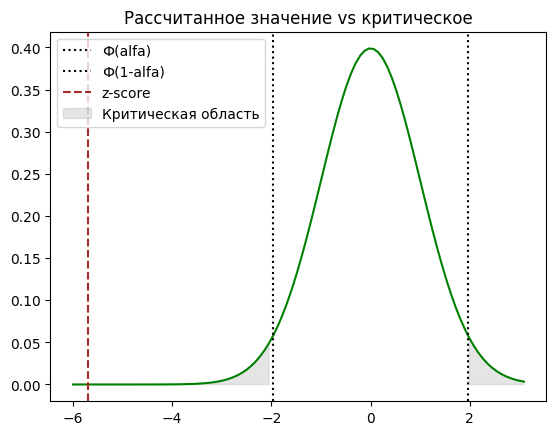

In [ ]:
x = np.linspace(norm.ppf(0.000000001), norm.ppf(0.999), 100)
y = norm.pdf(x)
plt.plot(x, y, color='green')
plt.axvline(norm.ppf(alfa/2), linestyle=':', color='black', label='Ф(alfa)')
plt.axvline(norm.ppf(1-alfa/2), linestyle=':', color='black', label='Ф(1-alfa)')
plt.axvline(z_score, linestyle='--', color='brown', label='z-score')
plt.fill_between(x, y, where=((x >= norm.ppf(1-alfa/2)) | (x <= norm.ppf(alfa/2))), color='grey', alpha=0.2, label='Критическая область')
plt.title('Рассчитанное значение vs критическое')
plt.legend()
plt.show()